In [284]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import BayesianRidge
import math
from sklearn.metrics import mean_squared_error


# Real Stock Thailand 

In [285]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [286]:
from pandas_datareader import data as pdr
from tqdm import tqdm,trange
stock_list = ['KBANK','SCB']
stock_data = []
stock_name = []
for quote in tqdm(stock_list):
    try:
        stock_data.append(pdr.get_data_yahoo(f'{quote}.BK', start='2009-01-01', end='2019-5-18'))
        stock_name.append(quote)
    except:
        print("Error:", sys.exc_info()[0])
        print("Description:", sys.exc_info()[1])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.16it/s]


In [287]:
print(stock_name)

['KBANK', 'SCB']


In [288]:
KBANK = stock_data[0] 
SCB = stock_data[1]

In [289]:
KBANK.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2535 entries, 2009-01-02 to 2019-05-17
Data columns (total 6 columns):
High         2535 non-null float64
Low          2535 non-null float64
Open         2535 non-null float64
Close        2535 non-null float64
Volume       2535 non-null float64
Adj Close    2535 non-null float64
dtypes: float64(6)
memory usage: 138.6 KB


In [290]:
SCB.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2535 entries, 2009-01-02 to 2019-05-17
Data columns (total 6 columns):
High         2535 non-null float64
Low          2535 non-null float64
Open         2535 non-null float64
Close        2535 non-null float64
Volume       2535 non-null float64
Adj Close    2535 non-null float64
dtypes: float64(6)
memory usage: 138.6 KB


In [291]:
KBANK_Train_set = KBANK[:].iloc[:,:] #KBANK[:'2017'].iloc[:,:] FOR PROOF OF CONCEPT
KBANK_Test_set = KBANK['2017':].iloc[:,:] #KBANK['2017':].iloc[:,:]
SCB_Train_set = SCB[:].iloc[:,:] #SCB[:'2017'].iloc[:,:] FOR PROOF OF CONCEPT
SCB_Test_set = SCB['2017':].iloc[:,:] #SCB['2017':].iloc[:,:]

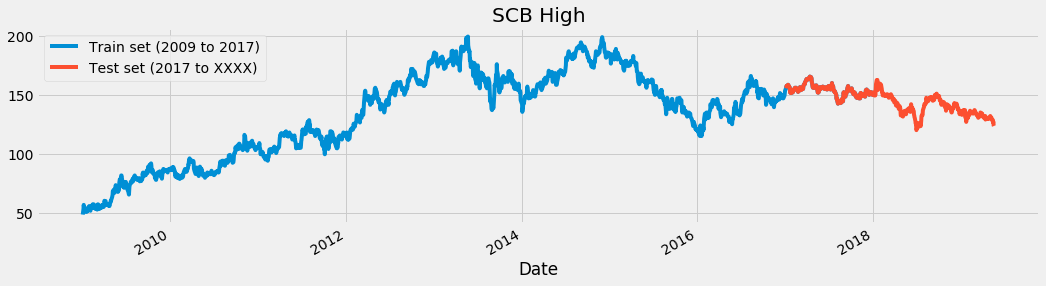

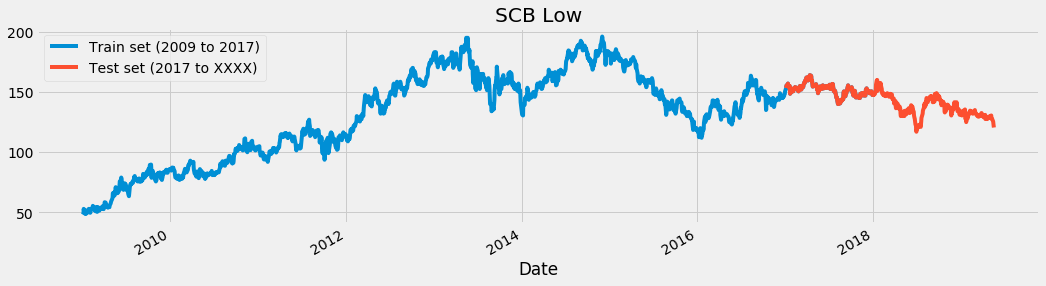

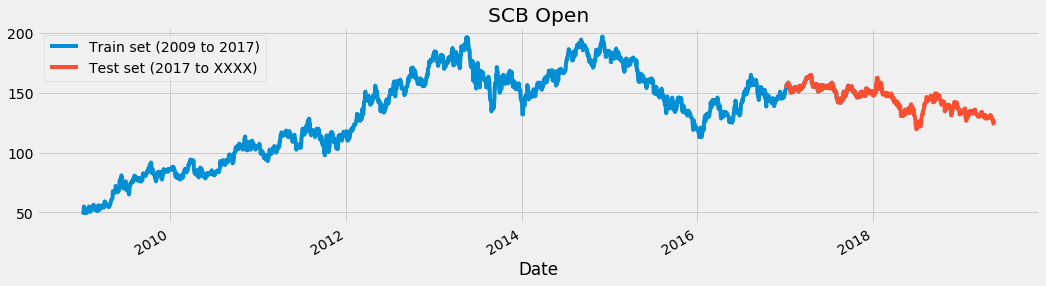

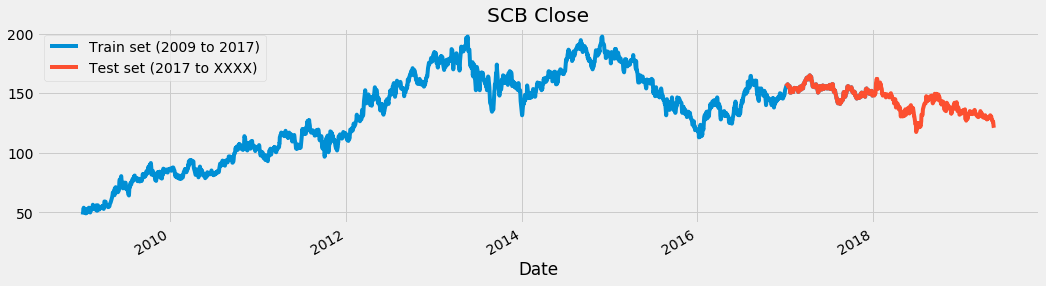

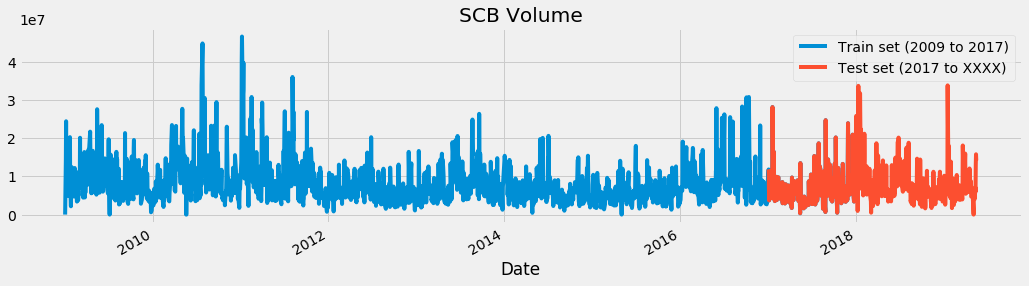

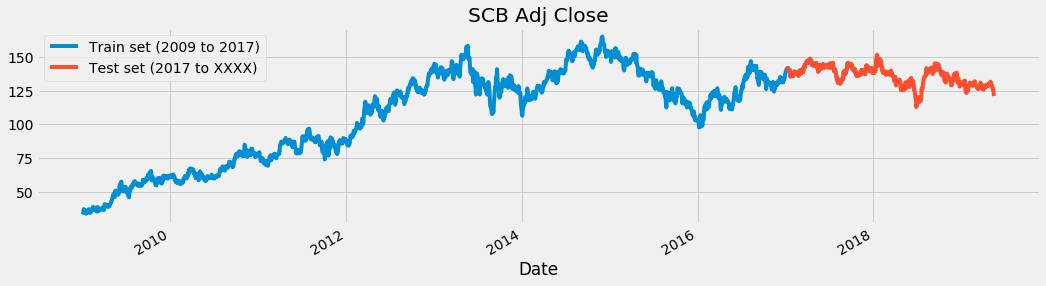

In [292]:
for a in list(stock_data[1].columns.values) :
    stock_data[1][a][:'2017'].plot(figsize=(16,4), legend = True)
    stock_data[1][a]['2017':].plot(figsize=(16,4), legend = True)
    plt.legend(['Train set (2009 to 2017)','Test set (2017 to XXXX)'])
    plt.title("SCB " + a)
    plt.show()

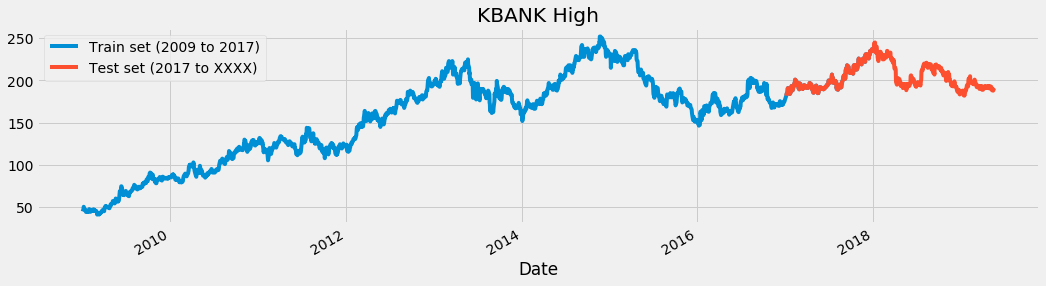

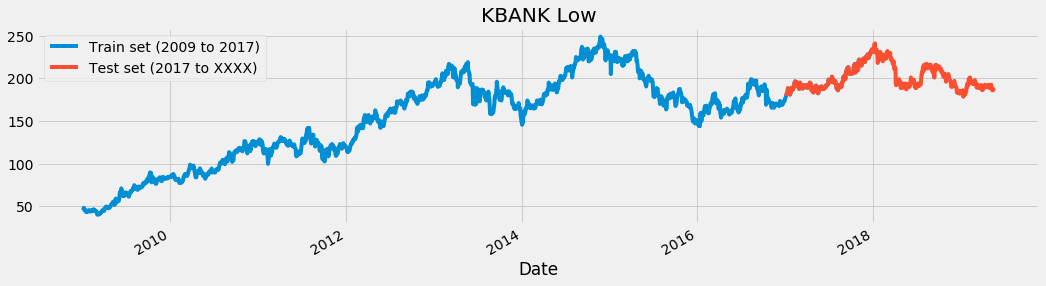

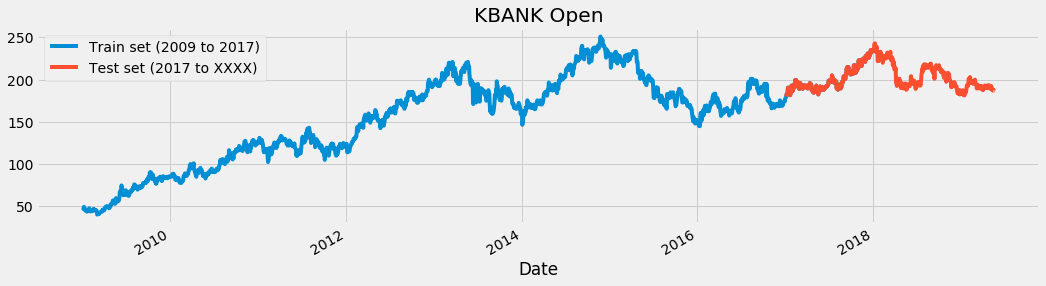

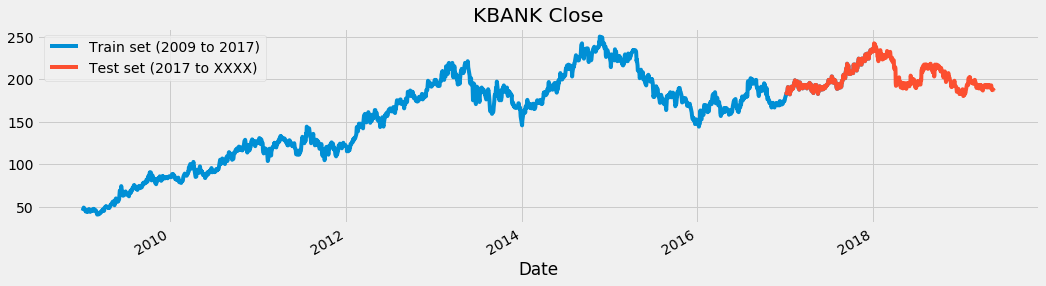

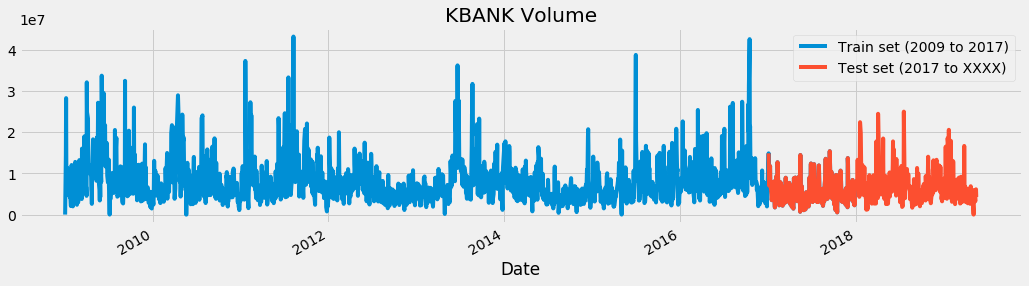

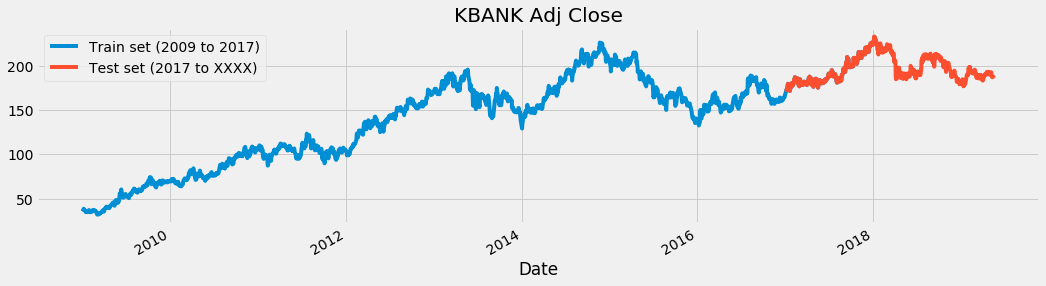

In [293]:
for a in list(stock_data[0].columns.values) :
    stock_data[0][a][:'2017'].plot(figsize=(16,4), legend = True)
    stock_data[0][a]['2017':].plot(figsize=(16,4), legend = True)
    plt.legend(['Train set (2009 to 2017)','Test set (2017 to XXXX)'])
    plt.title("KBANK " + a)
    plt.show()

In [294]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# Training

In [295]:
X_train = pd.concat([series_to_supervised(KBANK_Train_set.values, 30, 0,feat_name=stock_data[0].columns), series_to_supervised(SCB_Train_set.values, 30, 0,feat_name=stock_data[1].columns)], axis=1)
y_train_SCB = SCB_Train_set[30:]
y_train_KBANK = KBANK_Train_set[30:]

In [296]:
reg_SCB = MultiOutputRegressor(AdaBoostRegressor(base_estimator=BayesianRidge(n_iter=3000),n_estimators=100))
reg_SCB.fit(X_train, y_train_SCB)

MultiOutputRegressor(estimator=AdaBoostRegressor(base_estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=3000,
       normalize=False, tol=0.001, verbose=False),
         learning_rate=1.0, loss='linear', n_estimators=100,
         random_state=None),
           n_jobs=None)

In [297]:
reg_KBANK = MultiOutputRegressor(AdaBoostRegressor(base_estimator=BayesianRidge(n_iter=3000),n_estimators=100))
reg_KBANK.fit(X_train, y_train_KBANK)

MultiOutputRegressor(estimator=AdaBoostRegressor(base_estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=3000,
       normalize=False, tol=0.001, verbose=False),
         learning_rate=1.0, loss='linear', n_estimators=100,
         random_state=None),
           n_jobs=None)

In [298]:
X_test = pd.concat([series_to_supervised(KBANK_Test_set.values, 30, 0,feat_name=stock_data[0].columns), series_to_supervised(SCB_Test_set.values, 30, 0,feat_name=stock_data[1].columns)], axis=1)
y_test_SCB = SCB_Test_set[30:]
y_test_KBANK = KBANK_Test_set[30:]

In [299]:
predicted_Test_SCB = reg_SCB.predict(X_test)
predicted_Test_KBANK = reg_KBANK.predict(X_test)

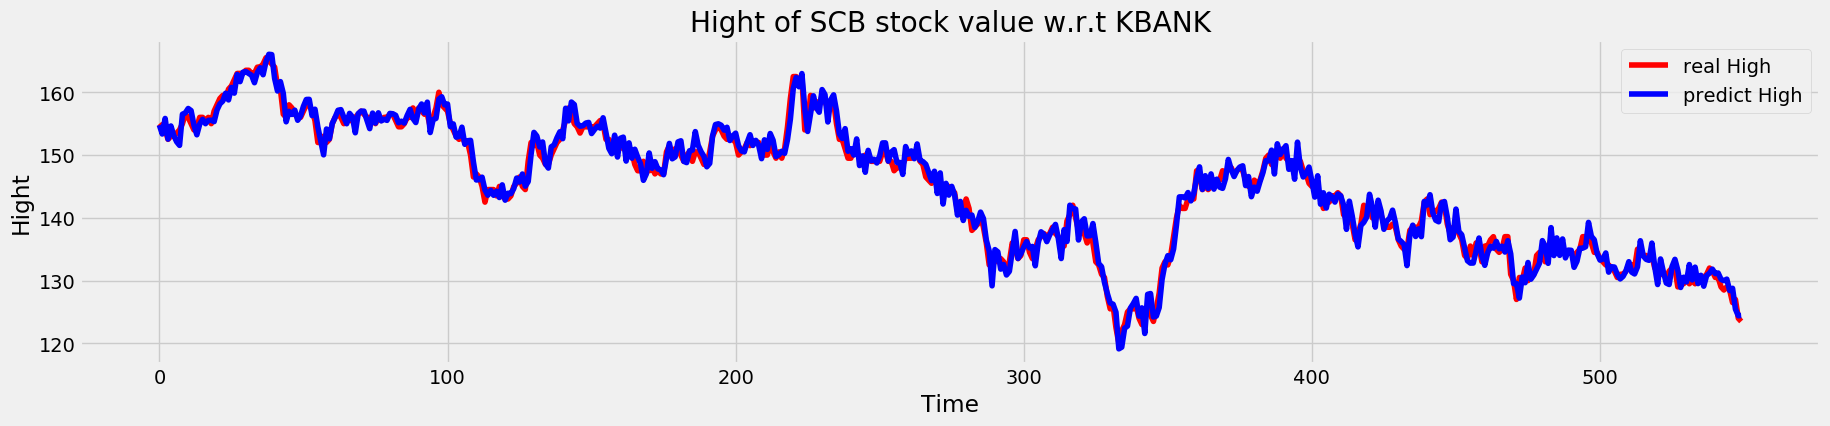

In [300]:
plt.figure(num=None, figsize=(20,4), dpi=100)
plt.plot(y_test_SCB['High'].values, color = 'red', label = 'real High')
plt.plot(predicted_Test_SCB[:,0], color = 'blue', label = 'predict High')
plt.title('Hight of SCB stock value w.r.t KBANK')
plt.xlabel('Time')
plt.ylabel('Hight')
plt.legend()
plt.show()

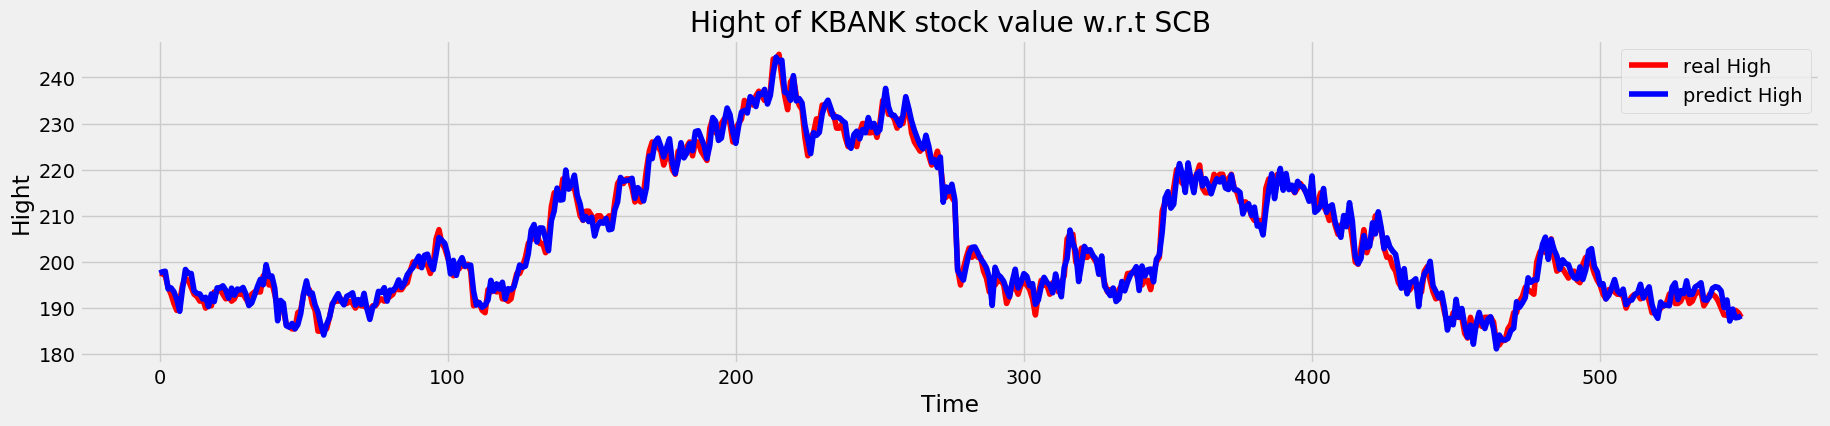

In [301]:
plt.figure(num=None, figsize=(20,4), dpi=100)
plt.plot(y_test_KBANK['High'].values, color = 'red', label = 'real High')
plt.plot(predicted_Test_KBANK[:,0], color = 'blue', label = 'predict High')
plt.title('Hight of KBANK stock value w.r.t SCB')
plt.xlabel('Time')
plt.ylabel('Hight')
plt.legend()
plt.show()

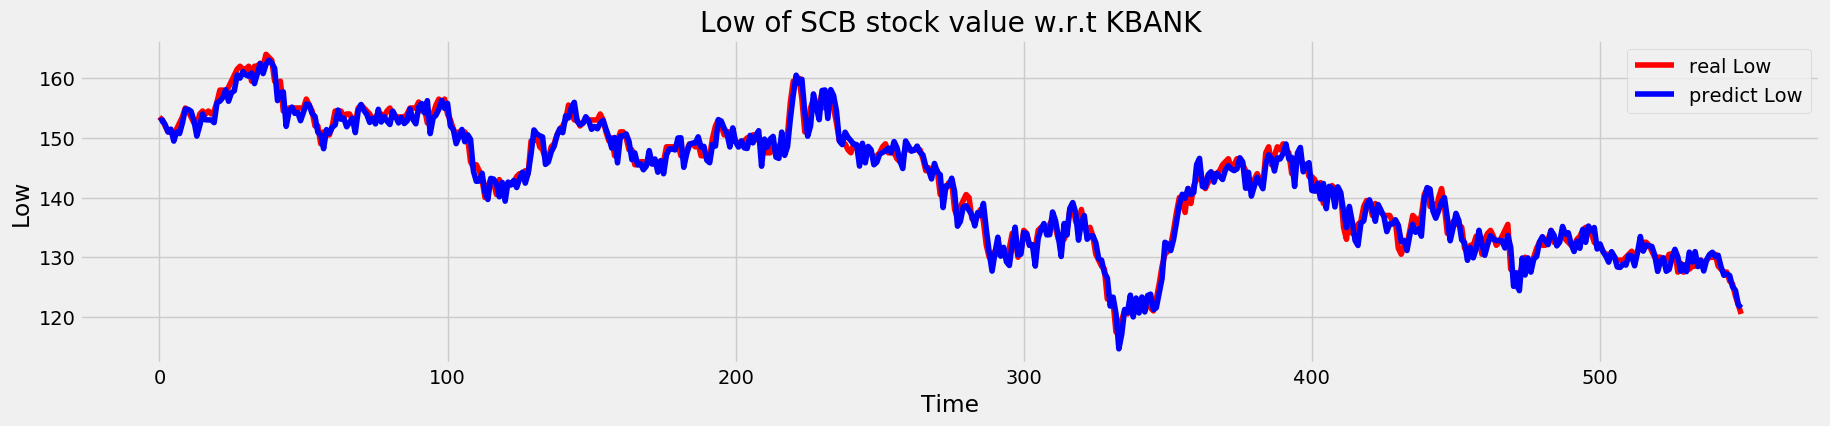

In [302]:
plt.figure(num=None, figsize=(20,4), dpi=100)
plt.plot(y_test_SCB['Low'].values, color = 'red', label = 'real Low')
plt.plot(predicted_Test_SCB[:,1], color = 'blue', label = 'predict Low')
plt.title('Low of SCB stock value w.r.t KBANK')
plt.xlabel('Time')
plt.ylabel('Low')
plt.legend()
plt.show()

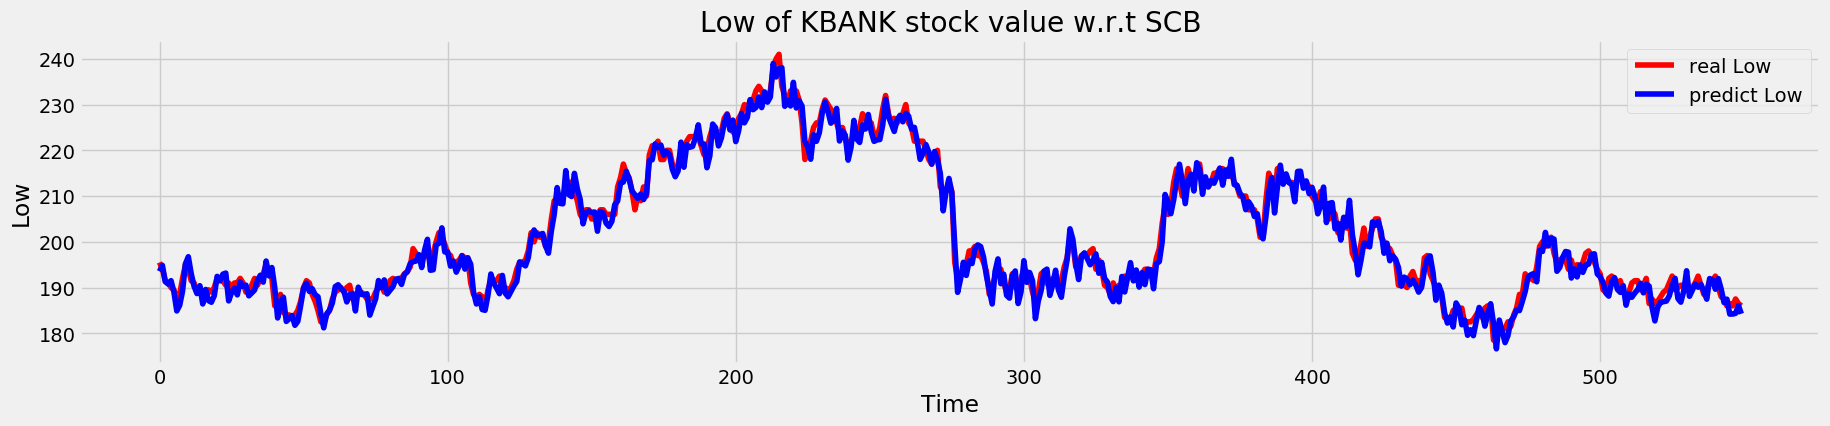

In [303]:
plt.figure(num=None, figsize=(20,4), dpi=100)
plt.plot(y_test_KBANK['Low'].values, color = 'red', label = 'real Low')
plt.plot(predicted_Test_KBANK[:,1], color = 'blue', label = 'predict Low')
plt.title('Low of KBANK stock value w.r.t SCB')
plt.xlabel('Time')
plt.ylabel('Low')
plt.legend()
plt.show()

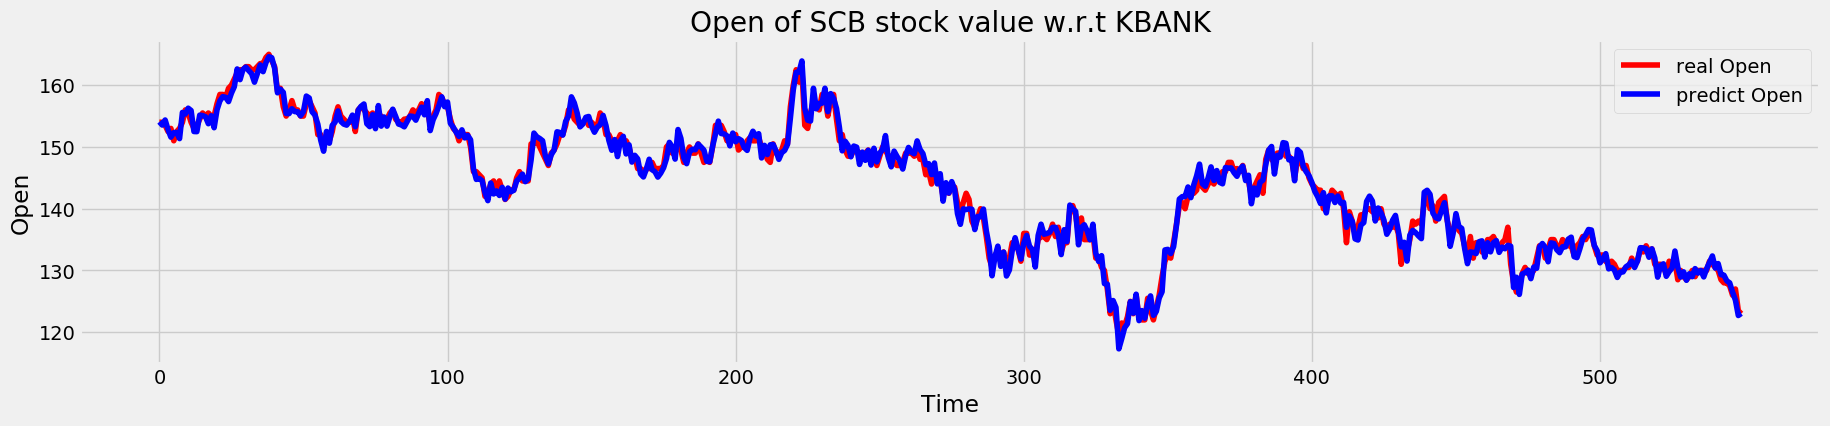

In [304]:
plt.figure(num=None, figsize=(20,4), dpi=100)
plt.plot(y_test_SCB['Open'].values, color = 'red', label = 'real Open')
plt.plot(predicted_Test_SCB[:,2], color = 'blue', label = 'predict Open')
plt.title('Open of SCB stock value w.r.t KBANK')
plt.xlabel('Time')
plt.ylabel('Open')
plt.legend()
plt.show()

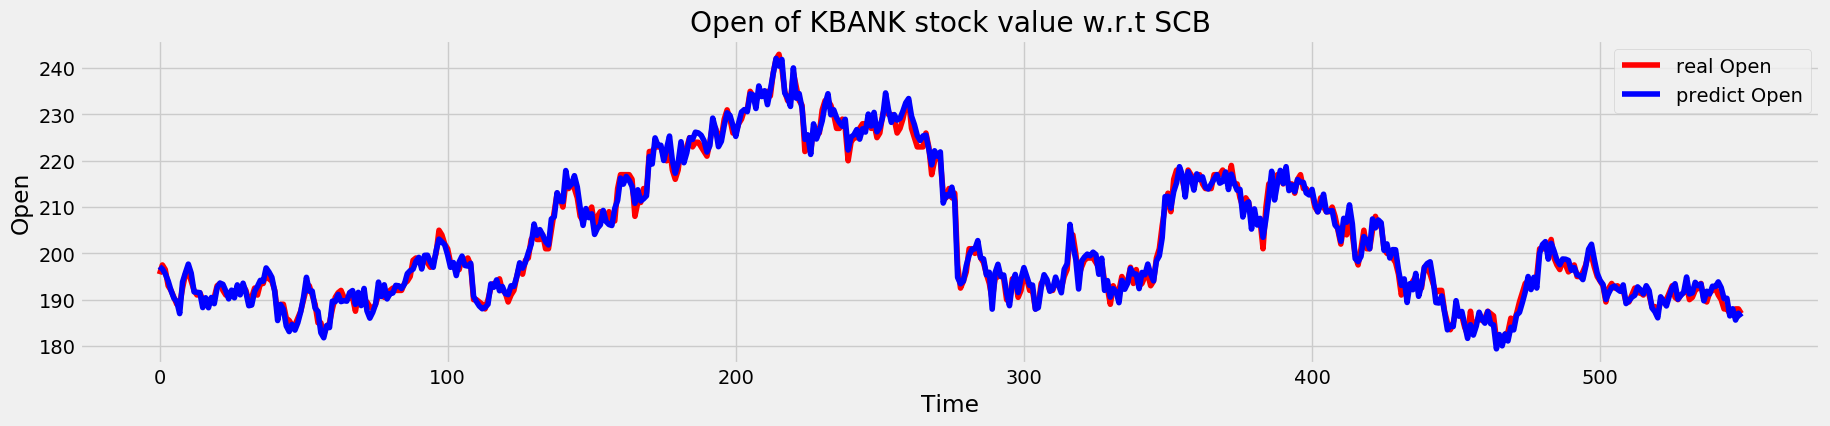

In [305]:
plt.figure(num=None, figsize=(20,4), dpi=100)
plt.plot(y_test_KBANK['Open'].values, color = 'red', label = 'real Open')
plt.plot(predicted_Test_KBANK[:,2], color = 'blue', label = 'predict Open')
plt.title('Open of KBANK stock value w.r.t SCB')
plt.xlabel('Time')
plt.ylabel('Open')
plt.legend()
plt.show()

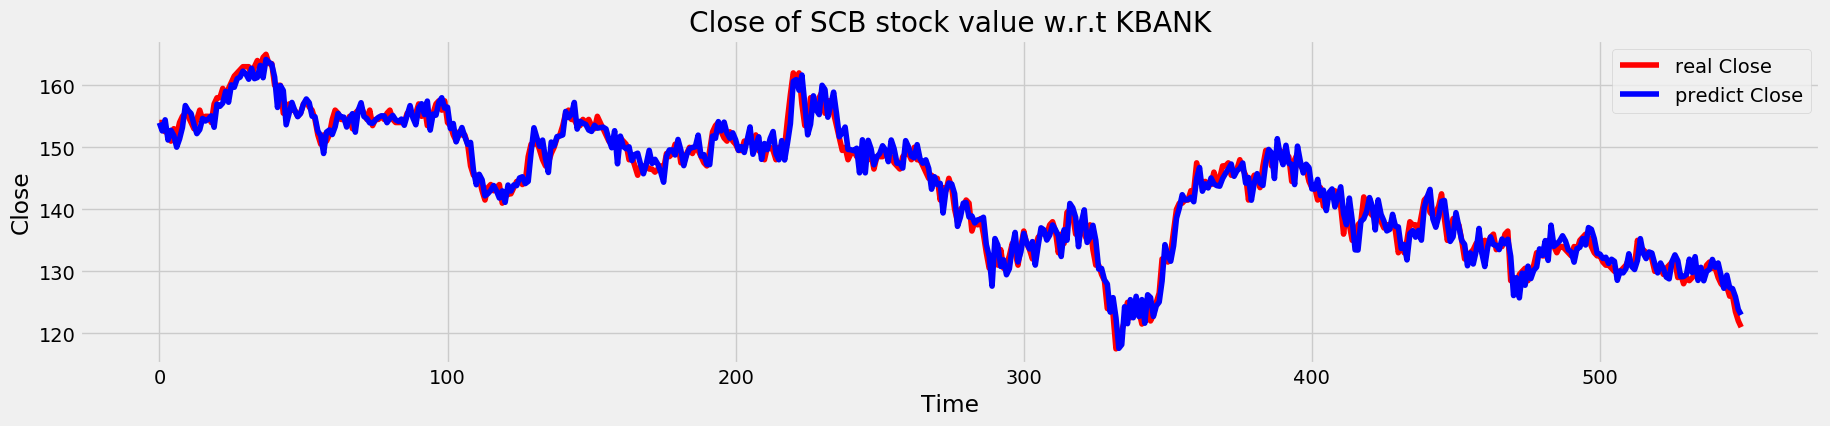

In [306]:
plt.figure(num=None, figsize=(20,4), dpi=100)
plt.plot(y_test_SCB['Close'].values, color = 'red', label = 'real Close')
plt.plot(predicted_Test_SCB[:,3], color = 'blue', label = 'predict Close')
plt.title('Close of SCB stock value w.r.t KBANK')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.show()

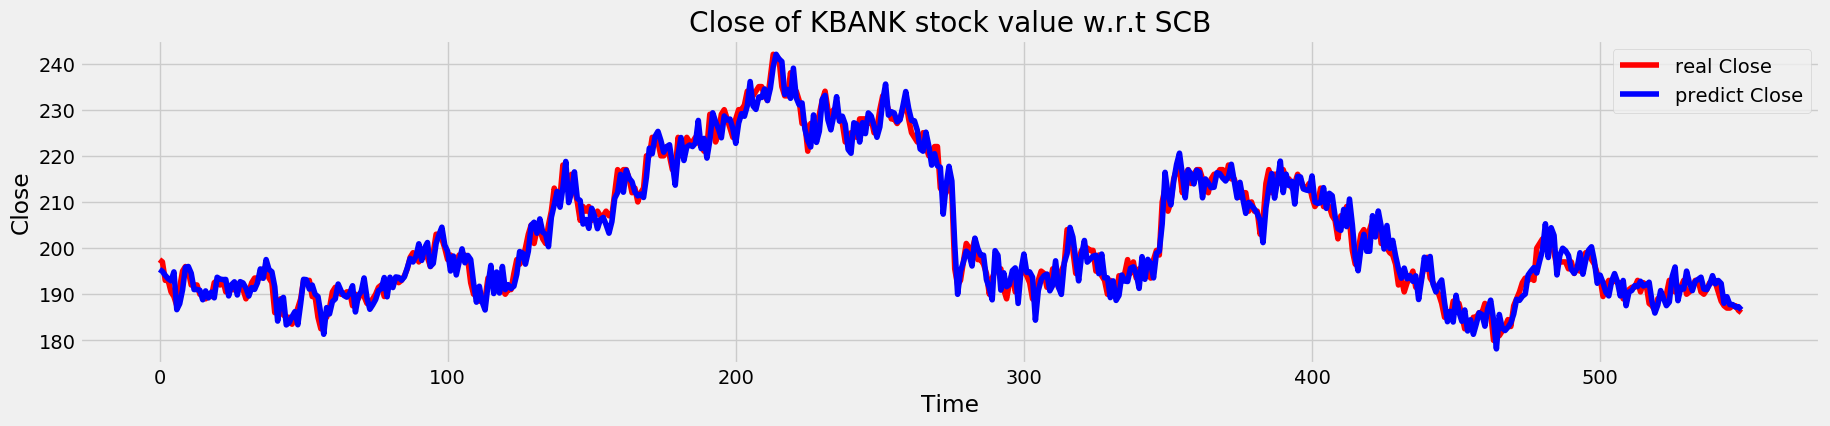

In [307]:
plt.figure(num=None, figsize=(20,4), dpi=100)
plt.plot(y_test_KBANK['Close'].values, color = 'red', label = 'real Close')
plt.plot(predicted_Test_KBANK[:,3], color = 'blue', label = 'predict Close')
plt.title('Close of KBANK stock value w.r.t SCB')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.show()

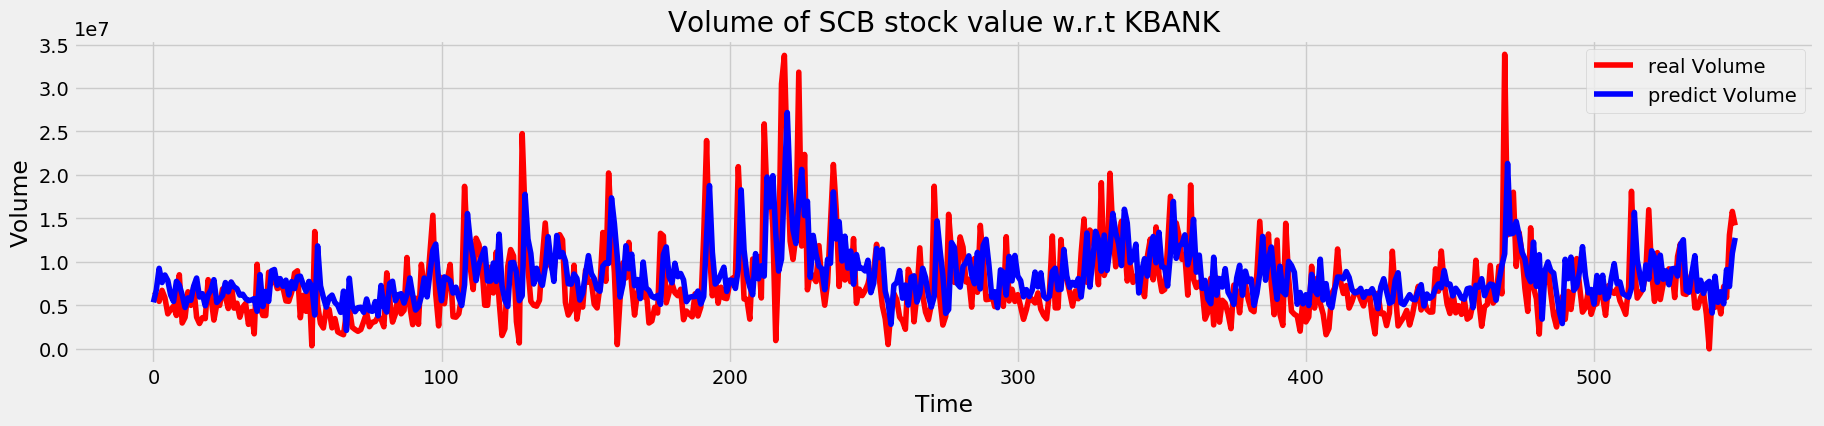

In [308]:
plt.figure(num=None, figsize=(20,4), dpi=100)
plt.plot(y_test_SCB['Volume'].values, color = 'red', label = 'real Volume')
plt.plot(predicted_Test_SCB[:,4], color = 'blue', label = 'predict Volume')
plt.title('Volume of SCB stock value w.r.t KBANK')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.show()

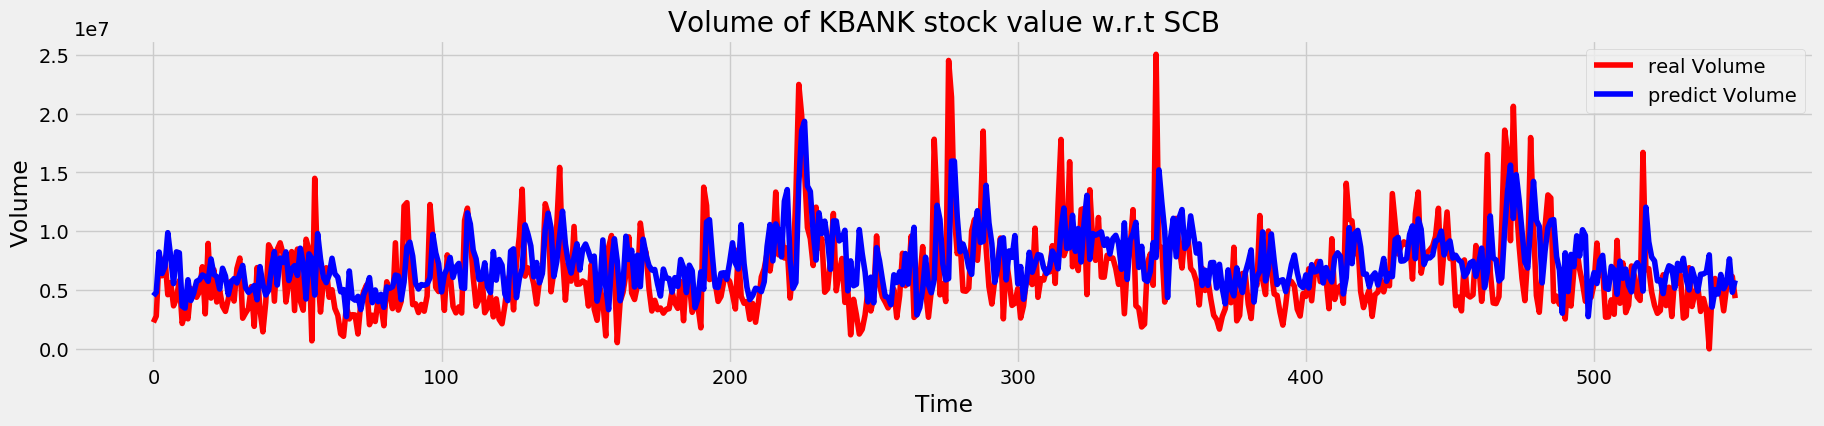

In [309]:
plt.figure(num=None, figsize=(20,4), dpi=100)
plt.plot(y_test_KBANK['Volume'].values, color = 'red', label = 'real Volume')
plt.plot(predicted_Test_KBANK[:,4], color = 'blue', label = 'predict Volume')
plt.title('Volume of KBANK stock value w.r.t SCB')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.show()

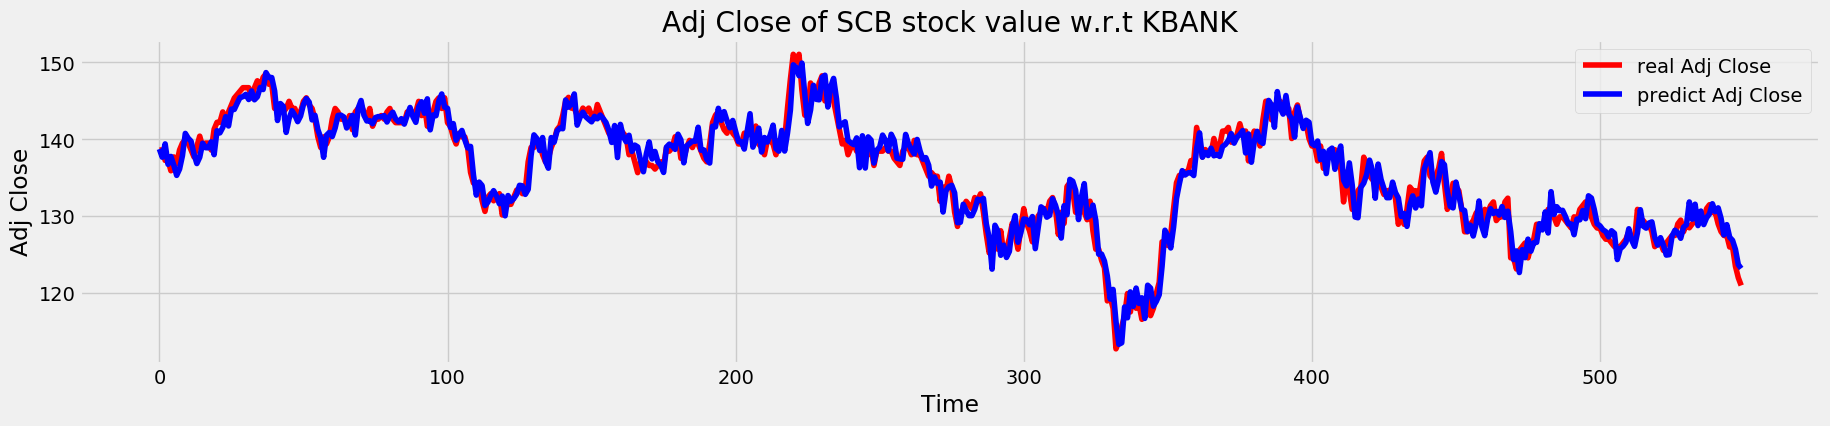

In [310]:
plt.figure(num=None, figsize=(20,4), dpi=100)
plt.plot(y_test_SCB['Adj Close'].values, color = 'red', label = 'real Adj Close')
plt.plot(predicted_Test_SCB[:,5], color = 'blue', label = 'predict Adj Close')
plt.title('Adj Close of SCB stock value w.r.t KBANK')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

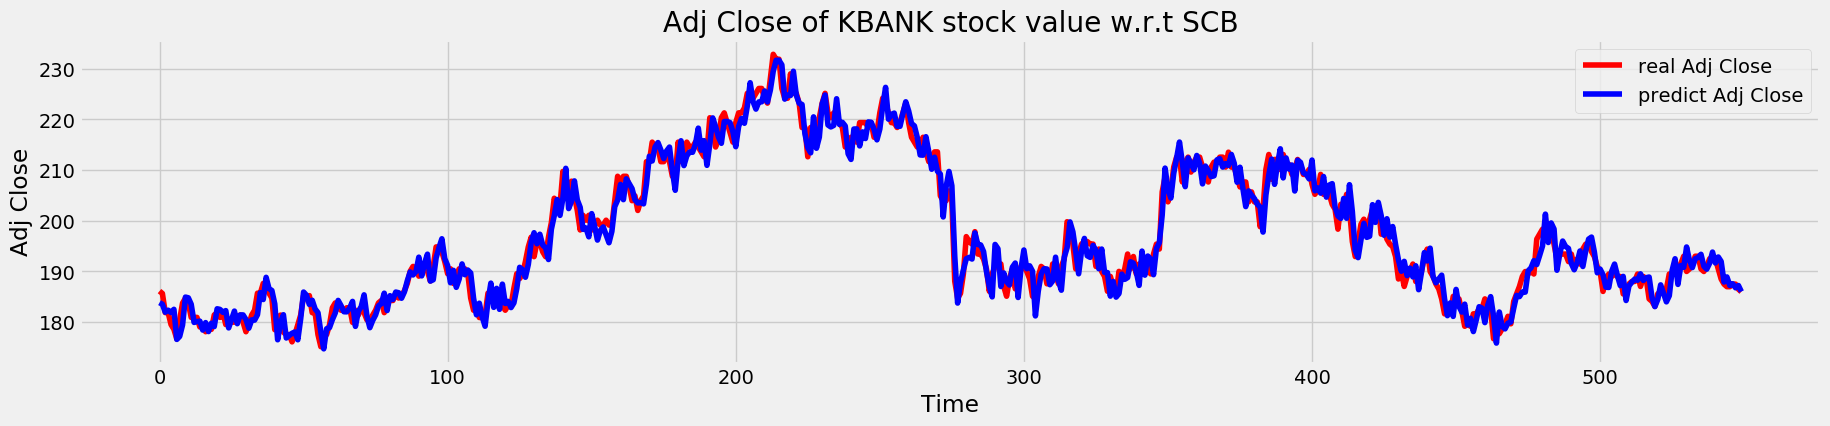

In [311]:
plt.figure(num=None, figsize=(20,4), dpi=100)
plt.plot(y_test_KBANK['Adj Close'].values, color = 'red', label = 'real Adj Close')
plt.plot(predicted_Test_KBANK[:,5], color = 'blue', label = 'predict Adj Close')
plt.title('Adj Close of KBANK stock value w.r.t SCB')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

# Mean Squared Error

## SCB

In [312]:
rmse_test_High_SCB = math.sqrt(mean_squared_error(y_test_SCB['High'].values,predicted_Test_SCB[:,0]))
rmse_test_Low_SCB = math.sqrt(mean_squared_error(y_test_SCB['Low'].values,predicted_Test_SCB[:,1]))
rmse_test_Open_SCB = math.sqrt(mean_squared_error(y_test_SCB['Open'].values,predicted_Test_SCB[:,2]))
rmse_test_Close_SCB = math.sqrt(mean_squared_error(y_test_SCB['Close'].values,predicted_Test_SCB[:,3]))
rmse_test_Volume_SCB = math.sqrt(mean_squared_error(y_test_SCB['Volume'].values,predicted_Test_SCB[:,4]))
rmse_test_AdjClose_SCB = math.sqrt(mean_squared_error(y_test_SCB['Adj Close'].values,predicted_Test_SCB[:,5]))


print("The root mean squared error of High on the test set",rmse_test_High_SCB)
print("The root mean squared error of Low on the test set",rmse_test_Low_SCB)
print("The root mean squared error of Open on the test set",rmse_test_Open_SCB)
print("The root mean squared error of Close on the test set",rmse_test_Close_SCB)
print("The root mean squared error of Volume on the test set",rmse_test_Volume_SCB)
print("The root mean squared error of Adj.Close on the test set",rmse_test_AdjClose_SCB)

The root mean squared error of High on the test set 1.465274412116761
The root mean squared error of Low on the test set 1.556065294050253
The root mean squared error of Open on the test set 1.1955839294250232
The root mean squared error of Close on the test set 1.841045715321211
The root mean squared error of Volume on the test set 4204674.883841737
The root mean squared error of Adj.Close on the test set 1.6327764355011984


## KBANK

In [313]:
rmse_test_High_KBANK = math.sqrt(mean_squared_error(y_test_KBANK['High'].values,predicted_Test_KBANK[:,0]))
rmse_test_Low_KBANK = math.sqrt(mean_squared_error(y_test_KBANK['Low'].values,predicted_Test_KBANK[:,1]))
rmse_test_Open_KBANK = math.sqrt(mean_squared_error(y_test_KBANK['Open'].values,predicted_Test_KBANK[:,2]))
rmse_test_Close_KBANK = math.sqrt(mean_squared_error(y_test_KBANK['Close'].values,predicted_Test_KBANK[:,3]))
rmse_test_Volume_KBANK = math.sqrt(mean_squared_error(y_test_KBANK['Volume'].values,predicted_Test_KBANK[:,4]))
rmse_test_AdjClose_KBANK = math.sqrt(mean_squared_error(y_test_KBANK['Adj Close'].values,predicted_Test_KBANK[:,5]))

print("The root mean squared error of High on the test set",rmse_test_High_KBANK)
print("The root mean squared error of Low on the test set",rmse_test_Low_KBANK)
print("The root mean squared error of Open on the test set",rmse_test_Open_KBANK)
print("The root mean squared error of Close on the test set",rmse_test_Close_KBANK)
print("The root mean squared error of Volume on the test set",rmse_test_Volume_KBANK)
print("The root mean squared error of Adj.Close on the test set",rmse_test_AdjClose_KBANK)

The root mean squared error of High on the test set 1.978574643378149
The root mean squared error of Low on the test set 2.1401147807547103
The root mean squared error of Open on the test set 1.4672673223600705
The root mean squared error of Close on the test set 2.674591130495414
The root mean squared error of Volume on the test set 3533598.4255156633
The root mean squared error of Adj.Close on the test set 2.509756029744896


# Tomorrow

__SCB__

In [314]:
Totaldata = pd.concat([series_to_supervised(KBANK.values, 30, 0,feat_name=stock_data[0].columns), series_to_supervised(SCB.values, 30, 0,feat_name=stock_data[1].columns)], axis=1)
Tomorrow_predicted_SCB = reg_SCB.predict(Totaldata)

In [315]:
Tomorrow_predicted_SCB = pd.DataFrame(data = Tomorrow_predicted_SCB, columns=stock_data[0].columns)

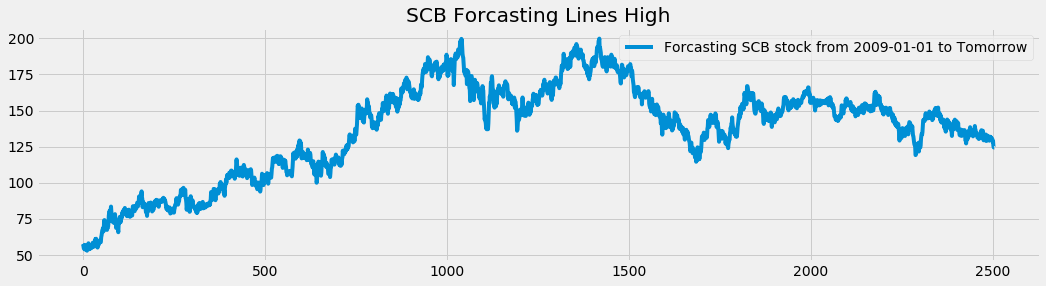

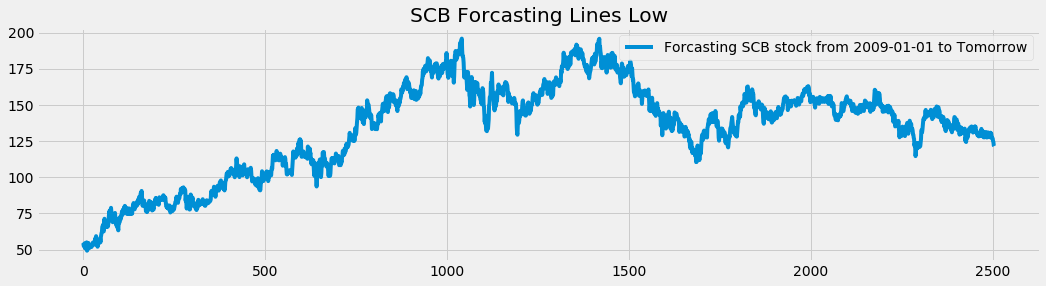

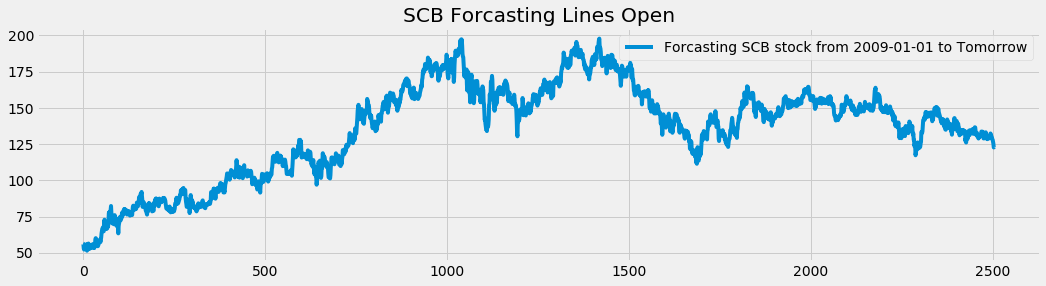

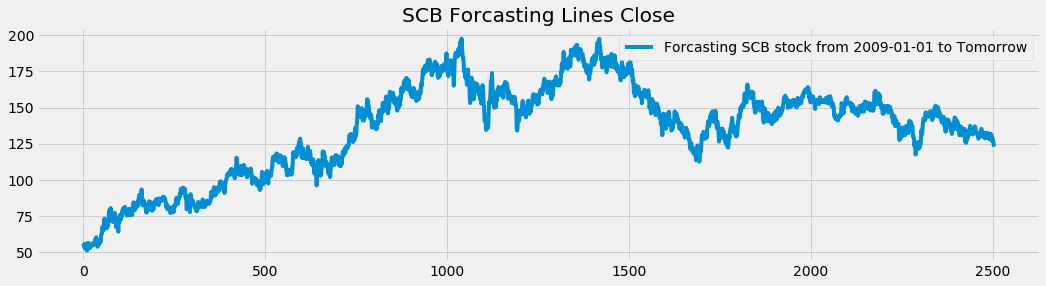

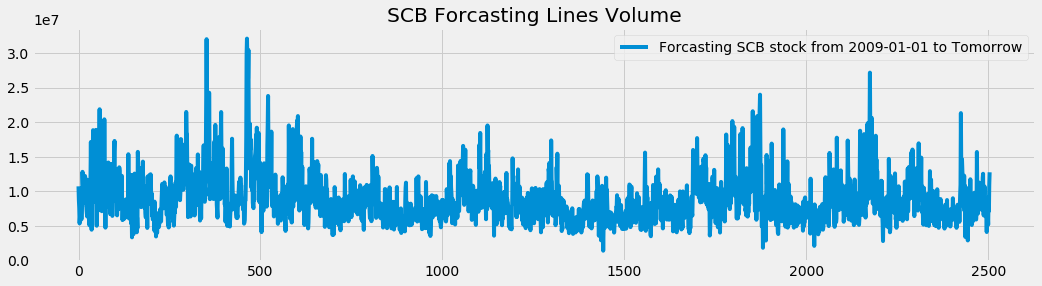

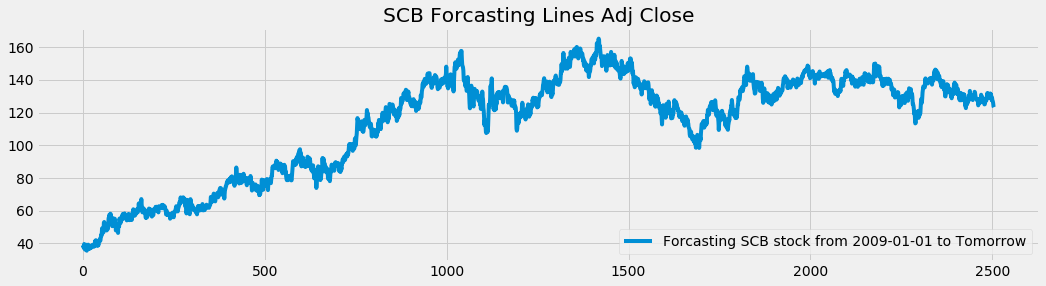

In [316]:
for a in list(Tomorrow_predicted_SCB.columns.values) :
    Tomorrow_predicted_SCB[a][:].plot(figsize=(16,4), legend = True)
    plt.legend(['Forcasting SCB stock from 2009-01-01 to Tomorrow'])
    plt.title("SCB Forcasting Lines " + a)
    plt.show()

In [317]:
Tomorrow_predicted_SCB.tail(1)

High         Low        Open       Close        Volume   Adj Close
2504  124.454398  121.527493  123.043948  122.990062  1.276447e+07  123.209934

__KBANK__

In [318]:
Tomorrow_predicted_KBANK = reg_KBANK.predict(Totaldata)
Tomorrow_predicted_KBANK = pd.DataFrame(data = Tomorrow_predicted_KBANK, columns=stock_data[1].columns)

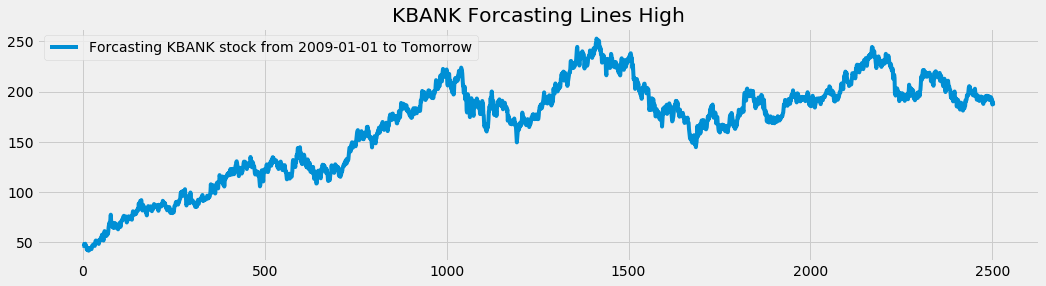

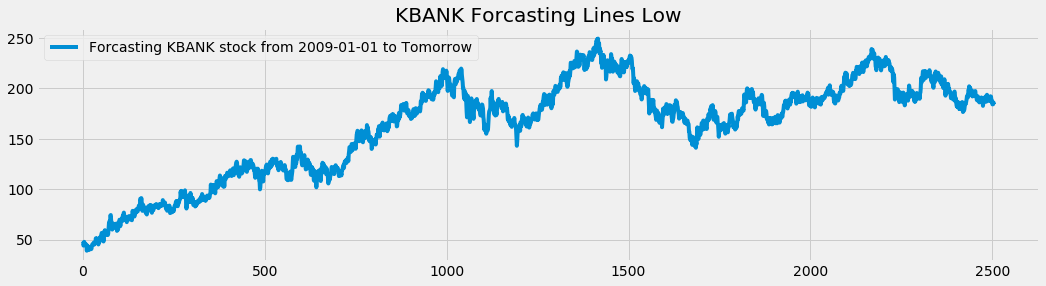

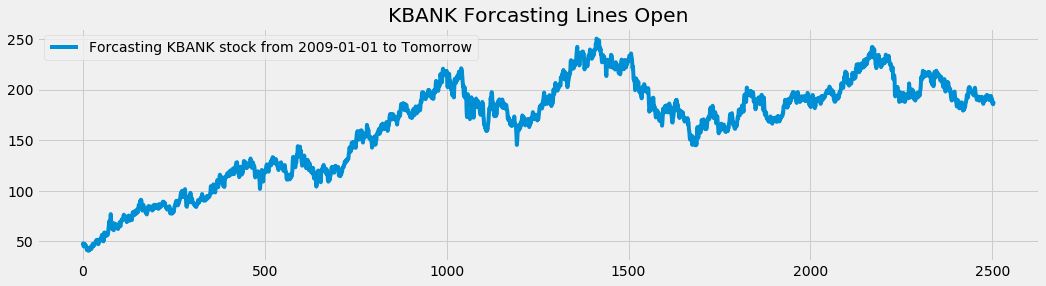

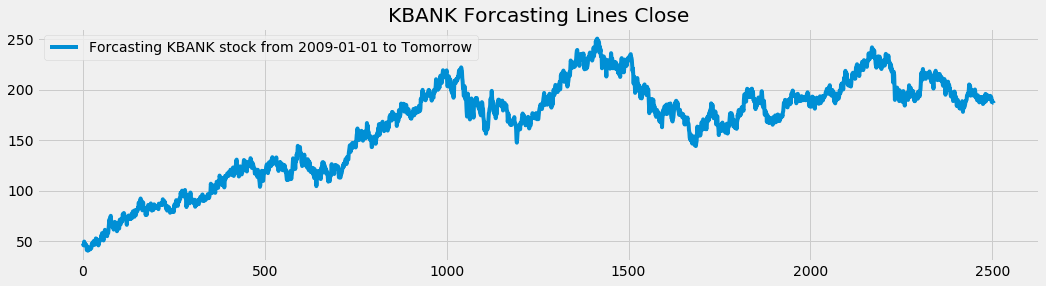

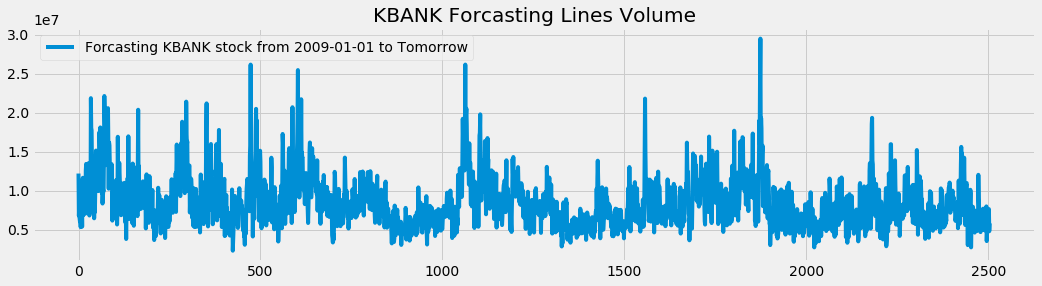

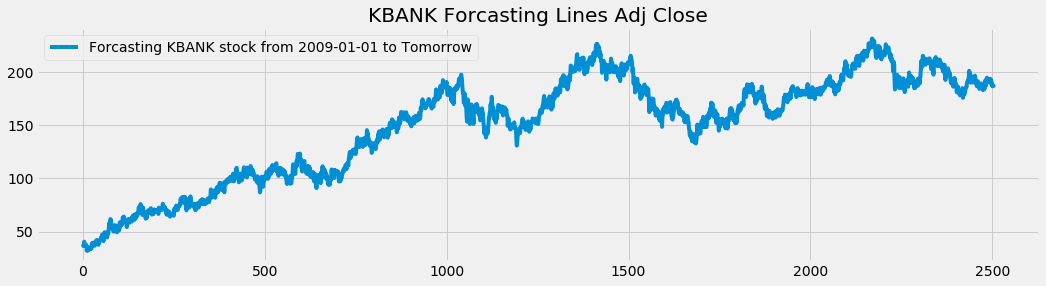

In [319]:
for a in list(Tomorrow_predicted_KBANK.columns.values) :
    Tomorrow_predicted_KBANK[a][:].plot(figsize=(16,4), legend = True)
    plt.legend(['Forcasting KBANK stock from 2009-01-01 to Tomorrow'])
    plt.title("KBANK Forcasting Lines " + a)
    plt.show()

In [320]:
Tomorrow_predicted_KBANK.tail(1)

High         Low       Open       Close        Volume   Adj Close
2504  188.336889  184.258154  186.24497  186.615128  5.823499e+06  186.034158

In [321]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Long Day

In [341]:
buffer_SCB = SCB.reset_index()
buffer_SCB = buffer_SCB.drop(columns=['Date'])
buffer_KBANK = KBANK.reset_index()
buffer_KBANK = buffer_KBANK.drop(columns=['Date'])
for i in range(7):
    Totaldata = pd.concat([series_to_supervised(buffer_KBANK.values, 30, 0,feat_name=stock_data[0].columns), series_to_supervised(buffer_SCB.values, 30, 0,feat_name=stock_data[1].columns)], axis=1)
    Tomorrow_predicted_SCB = reg_SCB.predict(Totaldata.tail(1))
    Tomorrow_predicted_KBANK = reg_KBANK.predict(Totaldata.tail(1))
    Tomorrow_predicted_SCB = pd.DataFrame(data = Tomorrow_predicted_SCB, columns=stock_data[0].columns)
    Tomorrow_predicted_KBANK = pd.DataFrame(data = Tomorrow_predicted_KBANK, columns=stock_data[1].columns)
    buffer_SCB = pd.concat([buffer_SCB,Tomorrow_predicted_SCB.tail(1)], ignore_index = True)
    buffer_KBANK = pd.concat([buffer_KBANK,Tomorrow_predicted_KBANK.tail(1)], ignore_index = True)
    

__SCB__

In [342]:
buffer_SCB[2535:]

High         Low        Open       Close        Volume   Adj Close
2535  124.454398  121.527493  123.043948  122.990062  1.276447e+07  123.209934
2536  124.069101  121.082892  121.157226  122.630449  1.243901e+07  122.381318
2537  124.121574  121.541522  122.740859  123.505133  1.250095e+07  123.071119
2538  123.395818  121.639902  121.622646  123.083382  1.120813e+07  122.828360
2539  124.488277  121.655896  123.156461  123.678459  1.324634e+07  123.311745
2540  123.120473  119.976848  122.972371  121.861501  1.070489e+07  121.826502
2541  124.589560  122.758124  124.073236  123.986277  1.222857e+07  124.115968

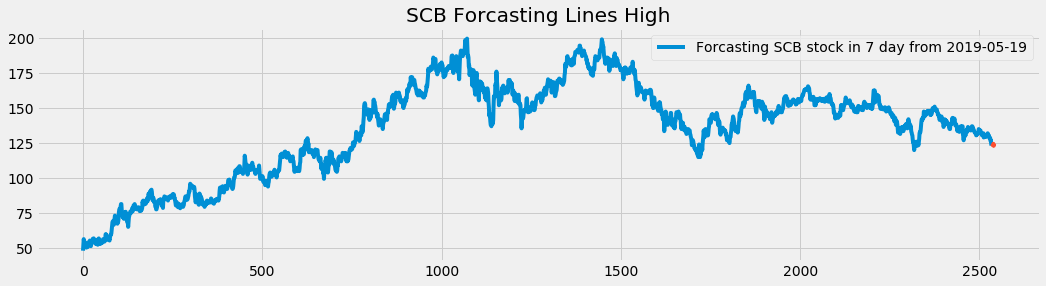

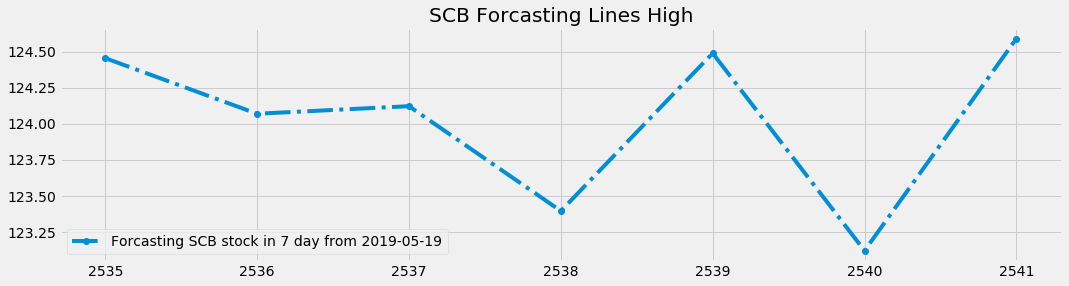

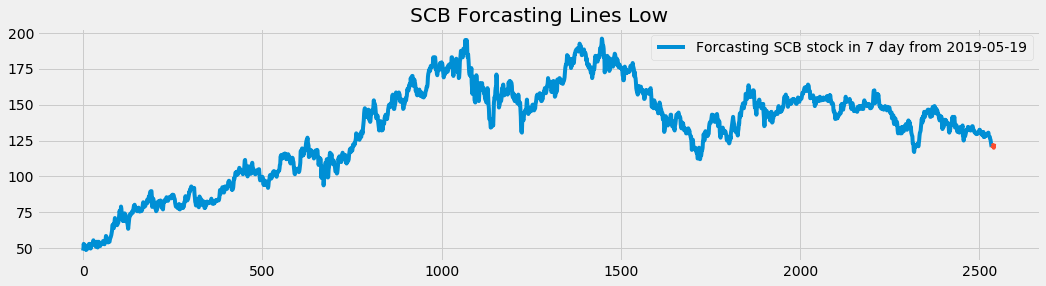

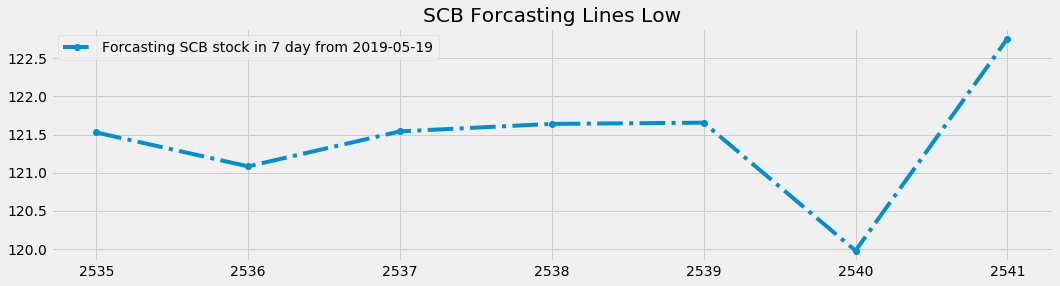

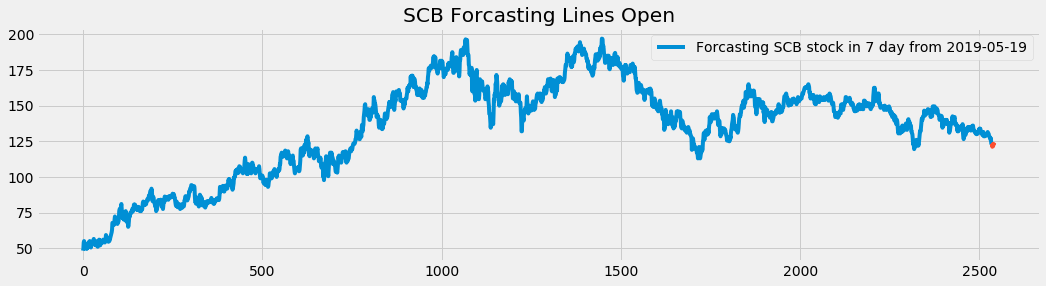

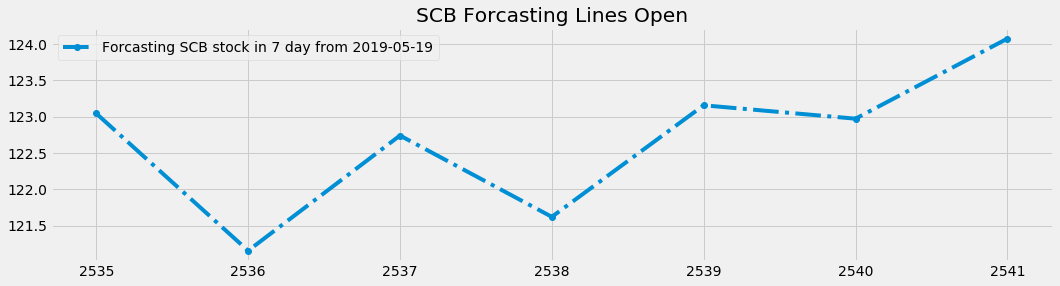

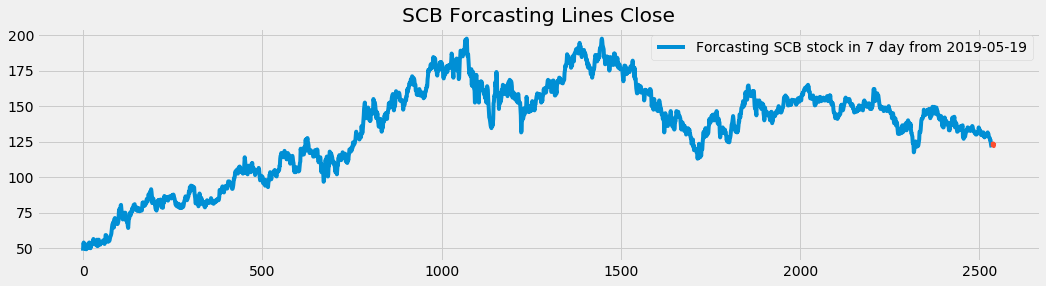

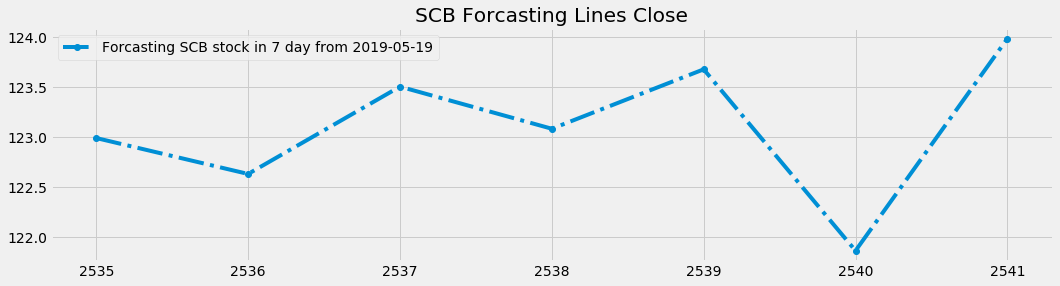

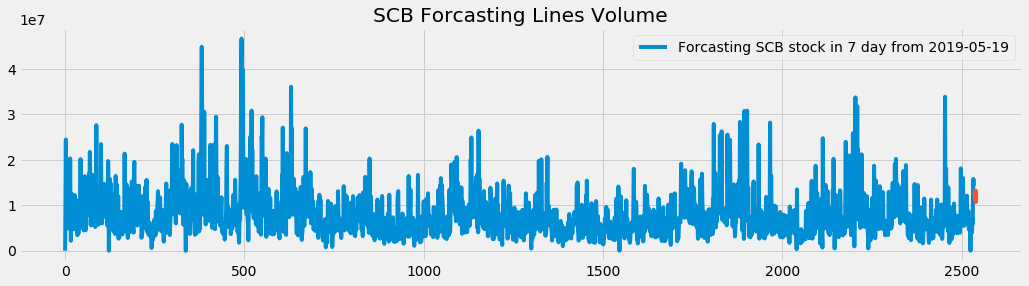

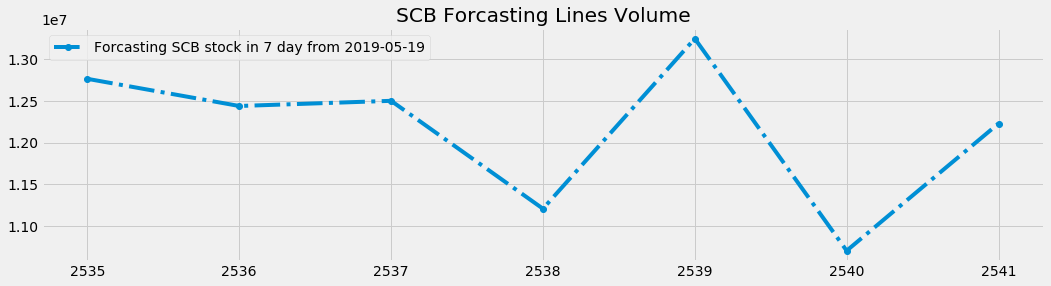

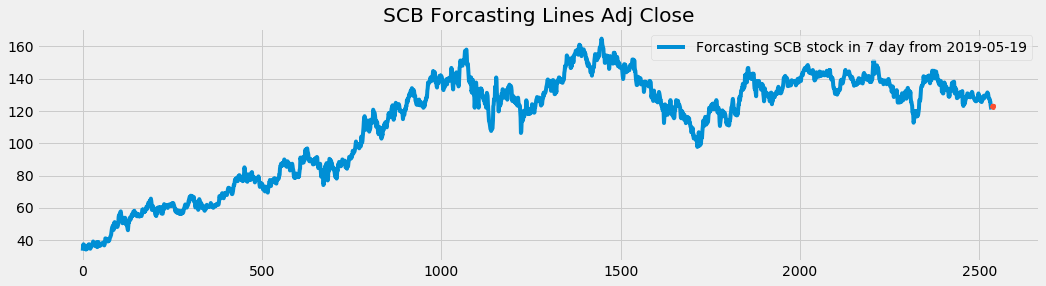

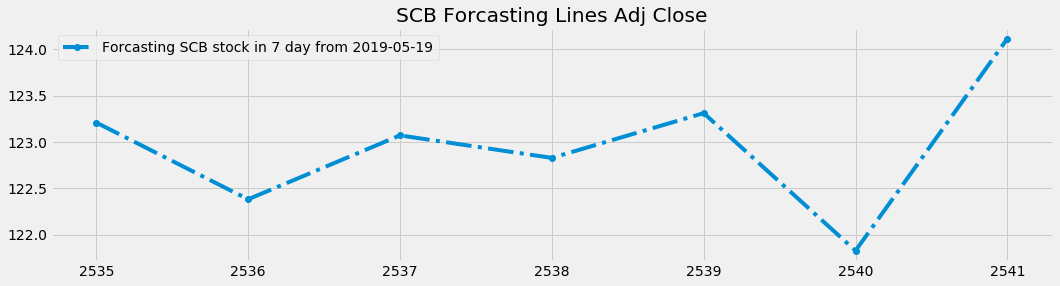

In [350]:
for a in list(buffer_SCB.columns.values) :
    buffer_SCB[a][:2535].plot(figsize=(16,4), legend = True)
    buffer_SCB[a][2535:].plot(figsize=(16,4), legend = True)
    plt.legend(['Forcasting SCB stock in 7 day from 2019-05-19'])
    plt.title("SCB Forcasting Lines " + a)
    plt.show()
    buffer_SCB[a][2535:].plot(figsize=(16,4), legend = True, marker='o', linestyle='dashdot')
    plt.legend(['Forcasting SCB stock in 7 day from 2019-05-19'])
    plt.title("SCB Forcasting Lines " + a)
    plt.show()

__KBANK__

In [344]:
buffer_KBANK[2535:]

High         Low        Open       Close        Volume   Adj Close
2535  188.336889  184.258154  186.244970  186.615128  5.823499e+06  186.034158
2536  188.260749  184.678403  186.196178  186.482804  6.114174e+06  186.063843
2537  187.500971  181.691016  184.150796  186.277695  7.097341e+06  185.957790
2538  187.787037  184.084859  186.393628  184.783020  5.693227e+06  184.448373
2539  187.296955  182.806825  184.435671  184.982618  7.949644e+06  185.355675
2540  185.066532  179.763599  184.079223  182.378314  6.523676e+06  182.341333
2541  187.168211  182.608896  184.313007  185.289297  8.063037e+06  185.772555

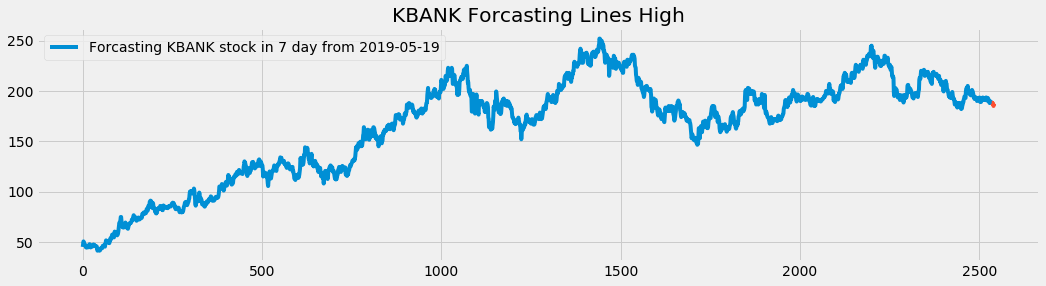

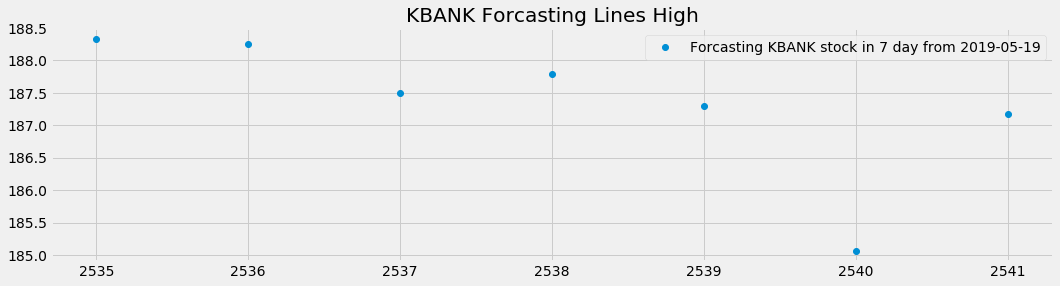

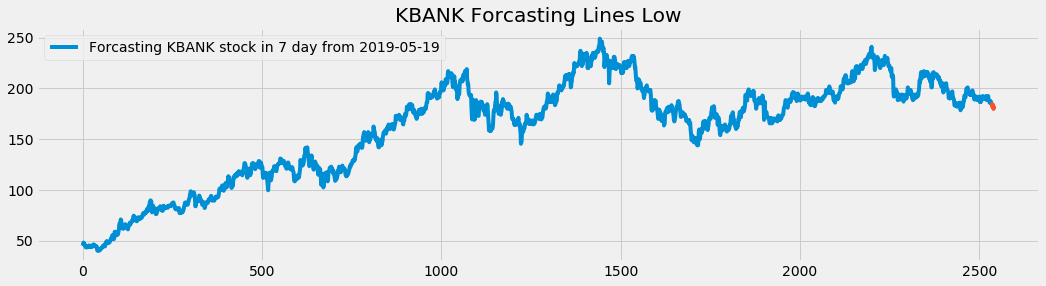

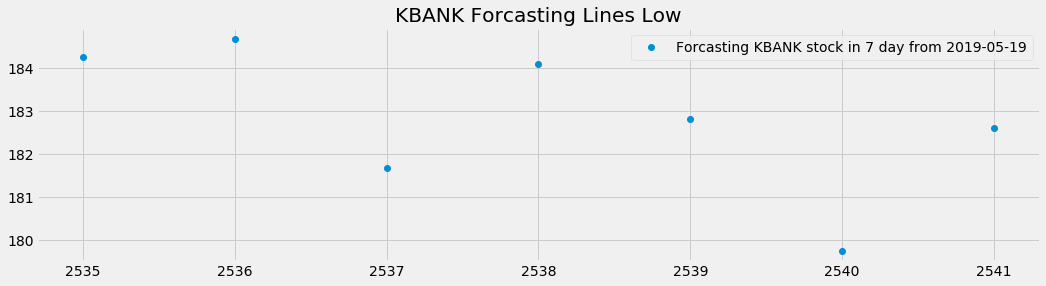

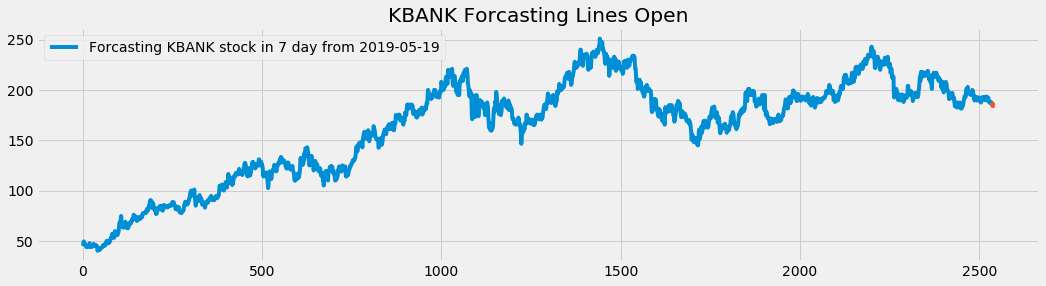

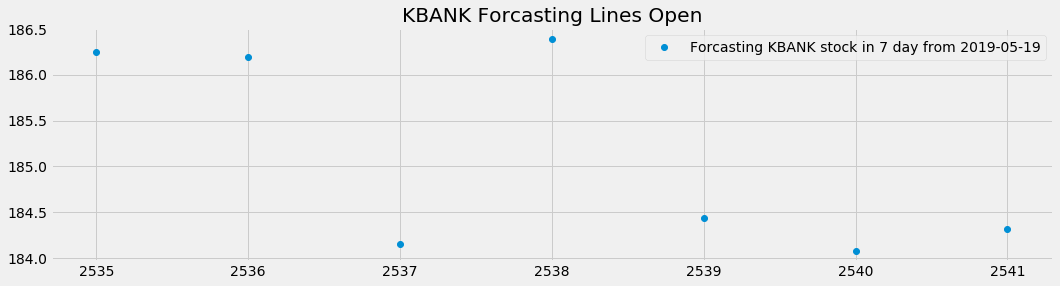

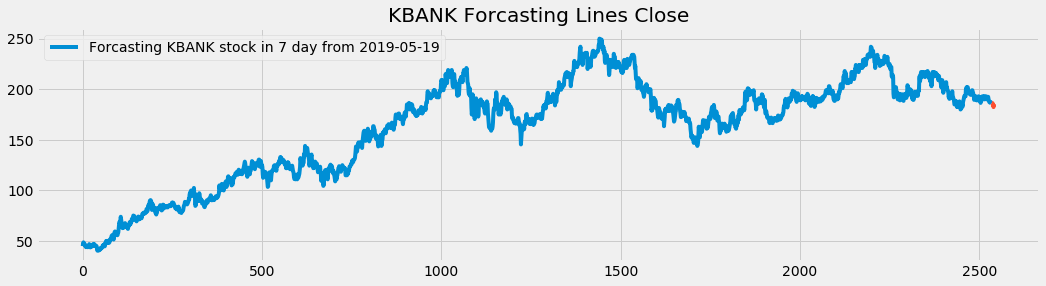

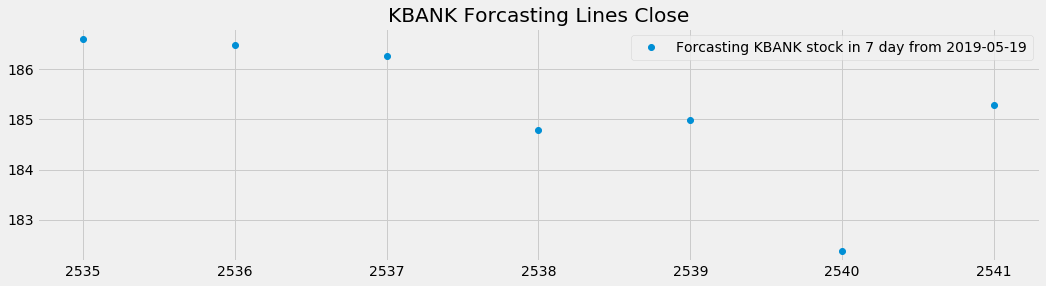

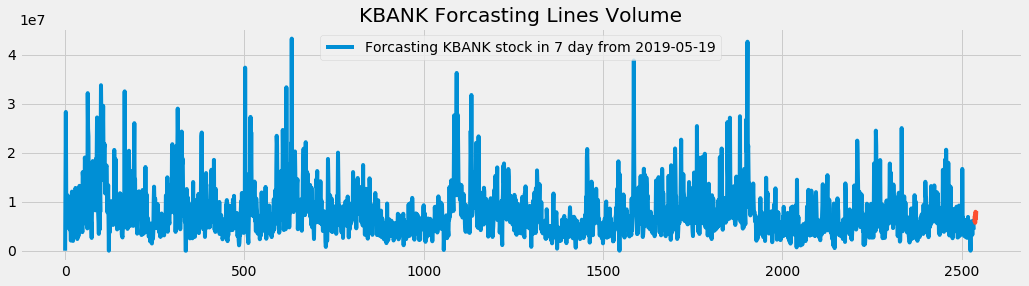

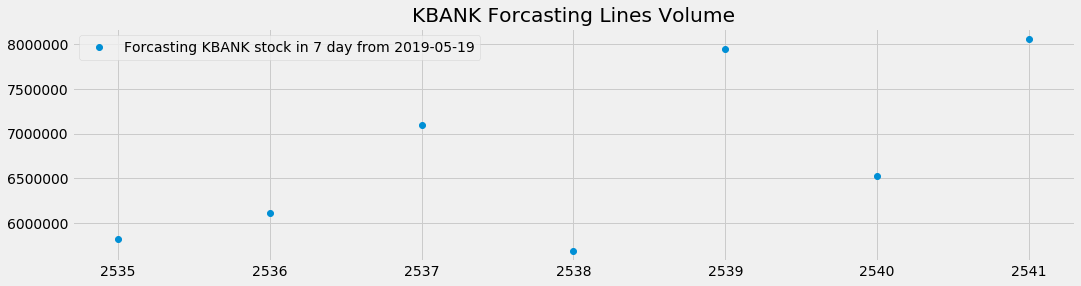

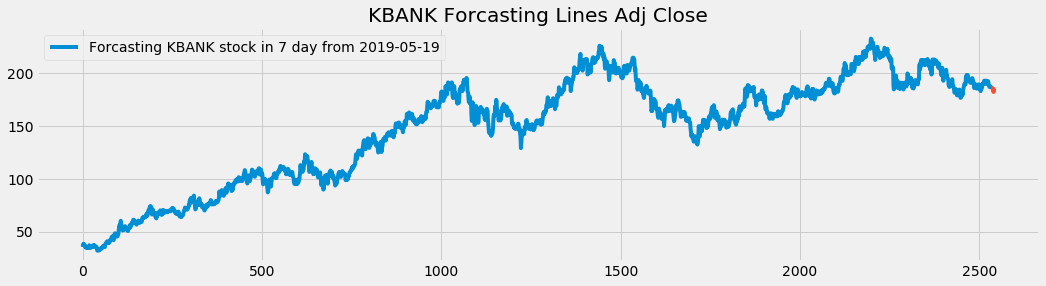

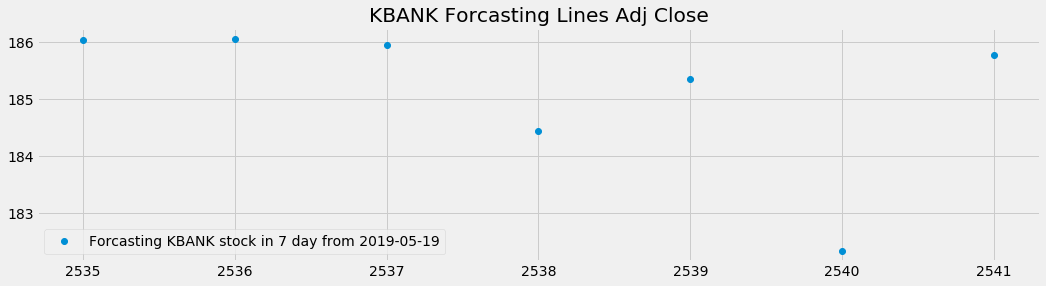

In [345]:
for a in list(buffer_KBANK.columns.values) :
    buffer_KBANK[a][:2535].plot(figsize=(16,4), legend = True)
    buffer_KBANK[a][2535:].plot(figsize=(16,4), legend = True)
    plt.legend(['Forcasting KBANK stock in 7 day from 2019-05-19'])
    plt.title("KBANK Forcasting Lines " + a)
    plt.show()
    buffer_KBANK[a][2535:].plot(figsize=(16,4), legend = True, marker='o', linestyle='None')
    plt.legend(['Forcasting KBANK stock in 7 day from 2019-05-19'])
    plt.title("KBANK Forcasting Lines " + a)
    plt.show()